# Quantum Fourier Transform
We saw that a Hadamard gate acting on a single qubit transforms it from the computational $Z$-basis to Fourier $X$-basis. The Quantum Fourier transorm is just the generalization of this transformation for several qubits, from computational basis to Fourier basis.
The mathematics behind the transformation is given below:
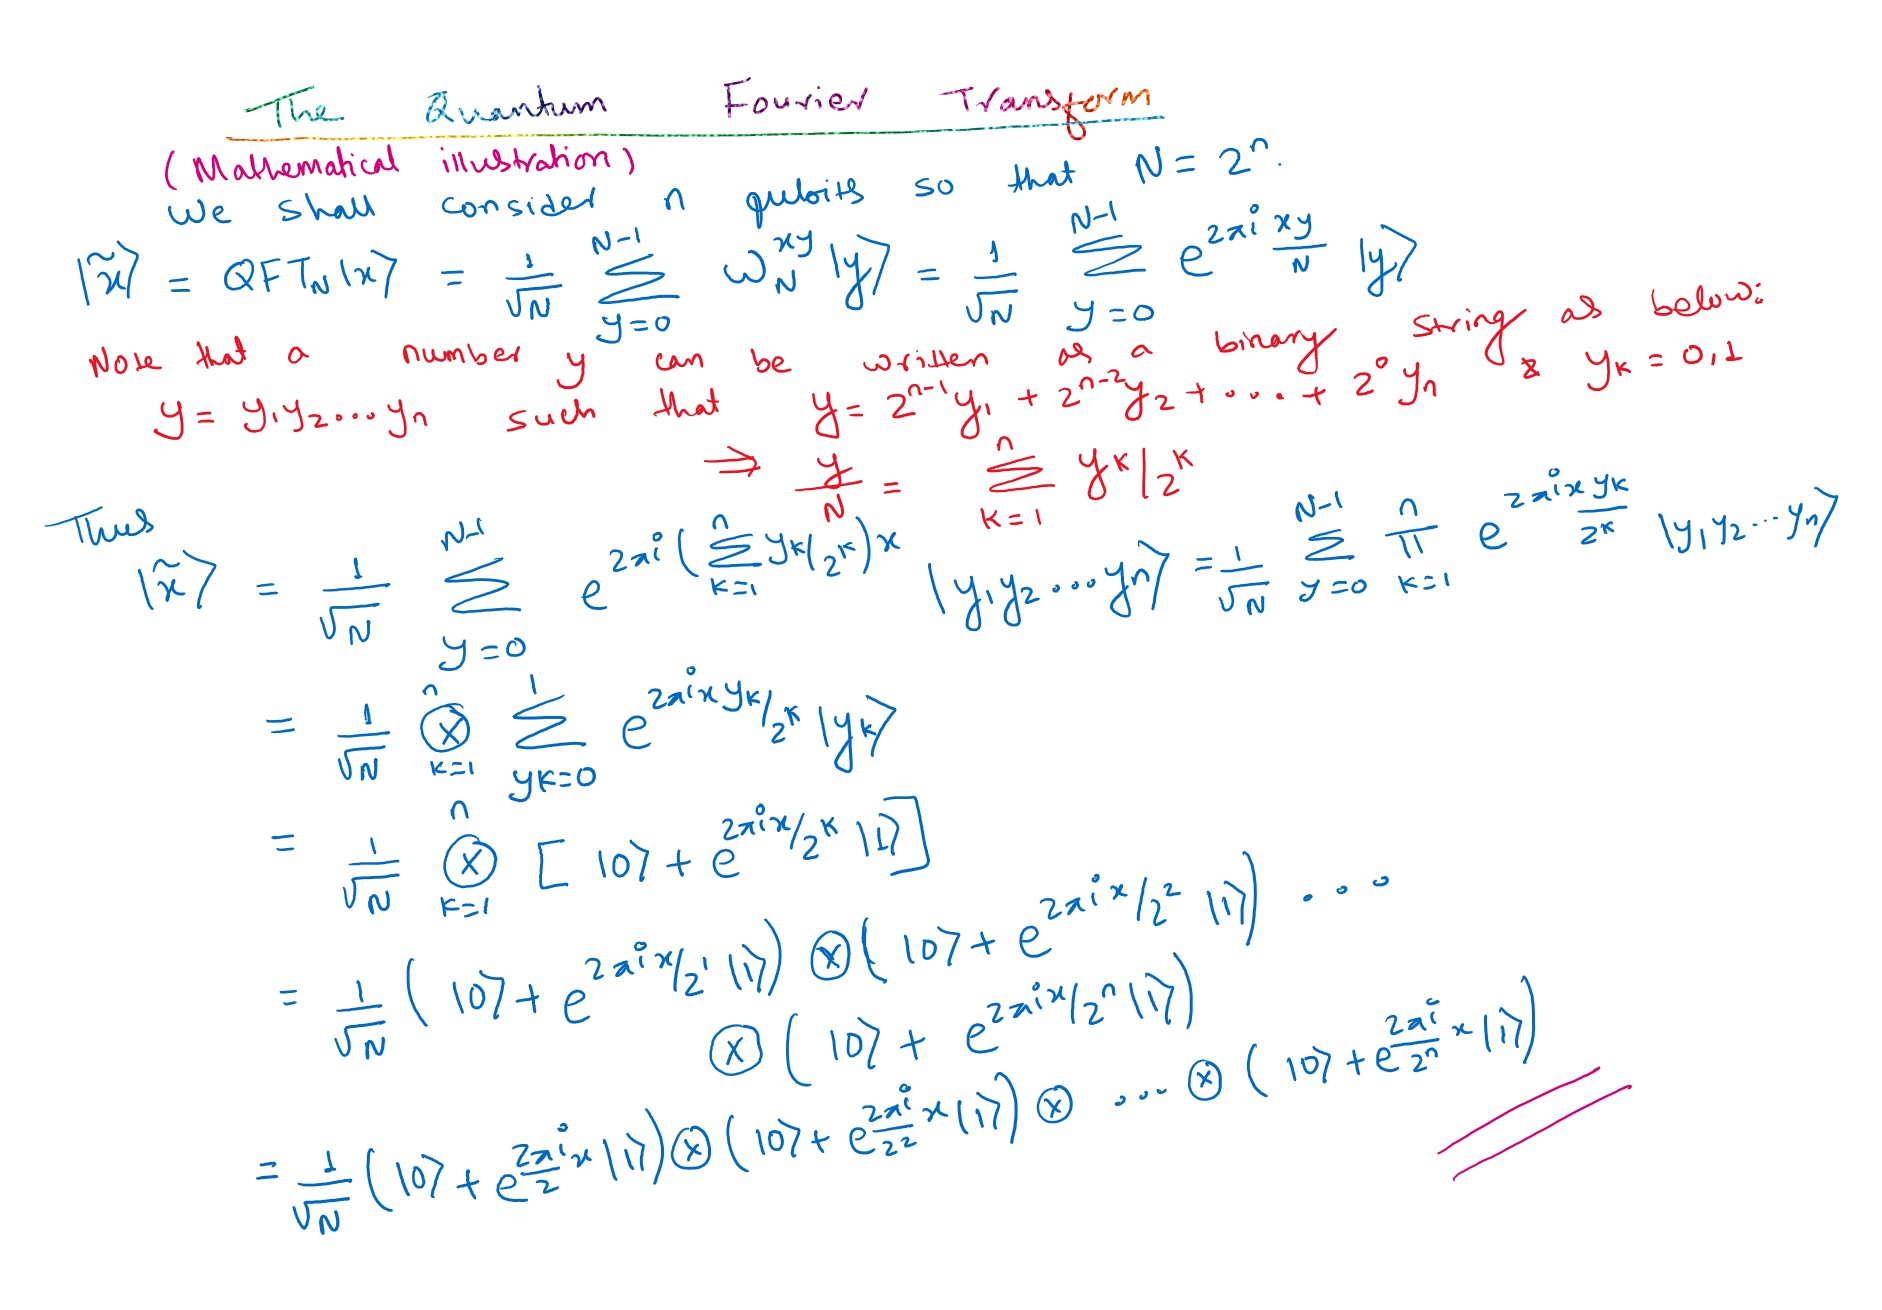

One important thing to note on Qiskit is the ordering of bits. Because the least significant bit is stored in the first qubit, one needs to reverse the ordering in the final stage.

## QFT using Qiskit Implementation

In [1]:
import numpy as np
from numpy import pi

from qiskit import QuantumCircuit, execute, Aer, IBMQ
from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor
from qiskit.visualization import plot_histogram, plot_bloch_multivector
%config InlineBackend.figure_format = 'svg'

In [4]:
# rotating the nost significant bit
def qft_rotations(circuit,n):
    if n == 0:
        return circuit
    n -=1
    circuit.h(n) # Applying Hadamard to the most significant bit
    for qubit in range(n):
        circuit.cu1(pi/2**(n - qubit), qubit, n)
    qft_rotations(circuit,n)

In [9]:
# Defining Swapping functions
def swap_registers(circuit,n):
    for qubit in range(n // 2):
        circuit.swap(qubit,n-1-qubit)
    return circuit

In [10]:
# Defnining the Quantum Fourier Transform 
def qft(circuit,n):
    """This performs the QFT on the first n qubits in circuit"""
    qft_rotations(circuit,n)
    swap_registers(circuit,n)
    return circuit

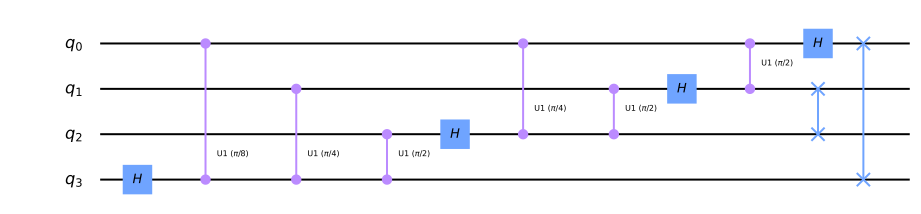

In [11]:
n = 4
qc = QuantumCircuit(n)
qft(qc,n)
qc.draw('mpl')

### Example

In [39]:
# QFT of 5 = '101'
qc = QuantumCircuit(3)

# Encoding the state 5
qc.x(0)
qc.x(2)
%config InlineBackend.figure_format ='svg'

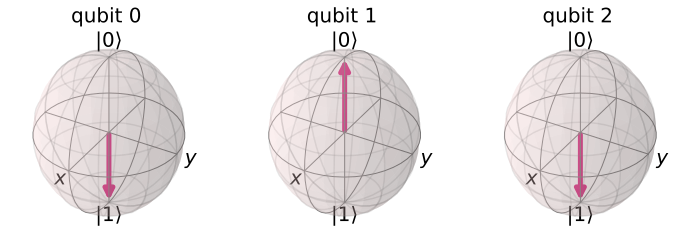

In [40]:
backend = Aer.get_backend('statevector_simulator')
statevector = execute(qc, backend = backend).result().get_statevector()
plot_bloch_multivector(statevector)

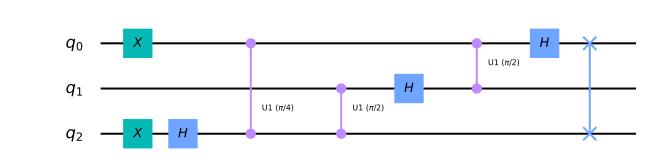

In [41]:
qc=qft(qc,3)
qc.draw('mpl')

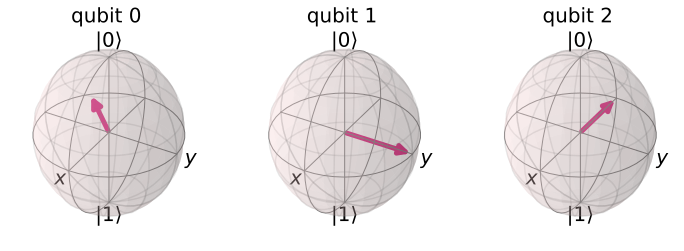

In [42]:
statevector = execute(qc, backend=backend).result().get_statevector()
plot_bloch_multivector(statevector)

### Running QFT on a Real Quantum Device

In [29]:
# defining Inverse QFT
def inverse_qft(circuit,n):
    qft_circ = qft(QuantumCircuit(n), n) # Creating the qft circuit of correct size
    invqft_circ = qft_circ.inverse() # Inversing the circuit
    circuit.append(invqft_circ,circuit.qubits[:n])
    return circuit.decompose()
    

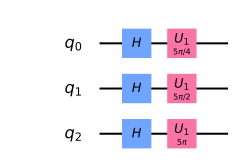

In [44]:
# writing fourier transform of 5
nqubits = 3
number = 5
qc = QuantumCircuit(nqubits)
for qubit in range(nqubits):
    qc.h(qubit)
qc.u1(number*pi/4,0)
qc.u1(number*pi/2,1)
qc.u1(number*pi,2)

qc.draw('mpl')

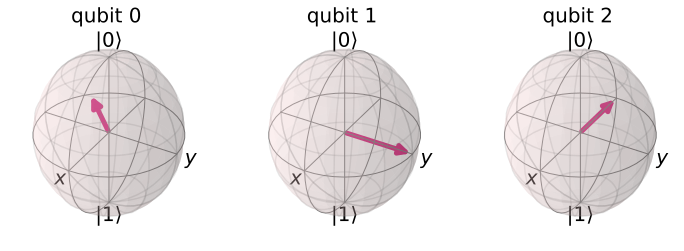

In [45]:
backend = Aer.get_backend("statevector_simulator")
statevector = execute(qc, backend=backend).result().get_statevector()
plot_bloch_multivector(statevector)

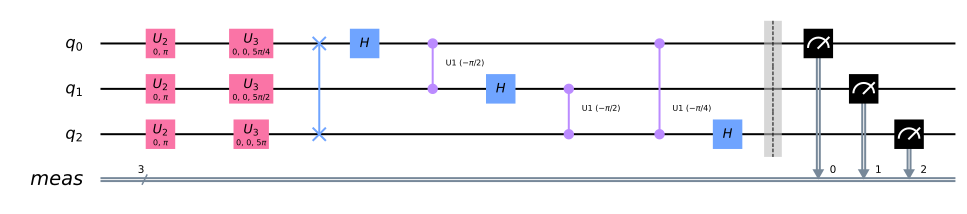

In [46]:
qc = inverse_qft(qc,nqubits)
qc.measure_all()
qc.draw('mpl')

In [47]:
# Load our saved IBMQ accounts and get the least busy backend device with less than or equal to nqubits
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= nqubits 
                                       and not x.configuration().simulator 
                                       and x.status().operational==True))
print("least busy backend: ", backend)

least busy backend:  ibmq_16_melbourne


In [55]:
shots = 2048
job = execute(qc, backend=backend, shots=shots, optimization_level=3)
job_monitor(job)

Job Status: job has successfully run


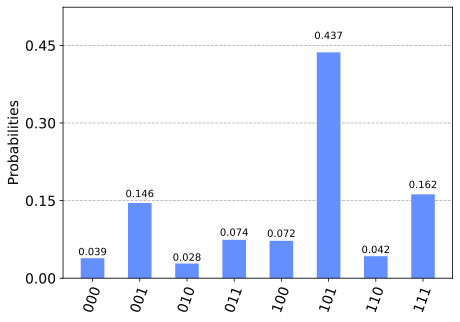

In [56]:
counts = job.result().get_counts()
plot_histogram(counts)